# Imports and creation of dataframes

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# PL league standings 2010-2022
for year in range(2014, 2023, 1):
    locals()['dftable_{}'.format(year)] = pd.read_csv('engineered_df/clubsize_'+str(year)+'.csv')

# Fully engineered tables
for year in range(2010, 2023, 1):
    locals()['df_{}'.format(year)] = pd.read_csv('tables 2010+/'+str(year)+'.csv')

# All transfers from  1992 onwards
df_transfers = pd.read_csv('premier-league.csv')

# PL wages 2013-2022
for year in range(2014, 2023, 1):
    locals()['dfwage_{}'.format(year)] = pd.read_csv('wages/wages_'+str(year-1)+'.csv', index_col=0)

# PL team value 2010-2022
for year in range(2010, 2023, 1):
    locals()['dfvalue_{}'.format(year)] = pd.read_csv('teamvalue/teamvalue_'+str(year-1)+'.csv', index_col=0)

# PL attendance 2010-2022
for year in range(2010, 2024, 1):
    locals()['dfatt_{}'.format(year)] = pd.read_csv('attendance/attendance_'+str(year)+'.csv', index_col=0)

In [11]:
# TRANSFERS
# Set new column with the year season ended
df_transfers['season_end'] = df_transfers['season'].str[5:]


def net_spend(df):
    """
    Function to transform the dataframe containing every transfer for every club across a single season into the total spend and net spend for each club during that season.
    :param the original dataframe:
    :return the new dataframe:
    """

    # Sum the incoming and outgoing transfer fees for each club
    df_slim = df.groupby(['club_name', 'transfer_movement']).sum('fee_cleaned').reset_index()[
        ['club_name', 'transfer_movement', 'fee_cleaned']]
    # Calculate the difference in a new column, 'net_spend'
    df_slim['net_spend'] = df_slim['fee_cleaned'] - df_slim['fee_cleaned'].shift(-1)
    # Tidy up the table: rename/remove redundant rows/cols, take 'FC' out of the team names.
    df_slim = df_slim[::2].reset_index()
    df_slim.rename(columns={'fee_cleaned': 'total_spend', 'club_name': 'Team'}, inplace=True)
    df_slim.drop(columns=['index', 'transfer_movement'], inplace=True)
    # df_slim['Team'] = df_slim['Team'].apply(tidy_names)
    return df_slim


# Cycle through each year(season), create a df for each season and transform to net spend
for year in range(1993, 2023, 1):
    locals()['dftransfer_{}'.format(year)] = df_transfers[df_transfers['season_end'] == str(year)]
    locals()['dftransfer_{}'.format(year)] = net_spend(locals()['dftransfer_{}'.format(year)])

# ATTENDANCE
#Calculate percentage attendance in new column, then remove useless columns
for year in range(2010, 2023, 1):
    dframe = locals()['dfatt_{}'.format(year)]
    dframe['att_percent'] = dframe['av_attendance'] / dframe['capacity']
    dframe.drop(columns=['capacity', 'av_attendance'], inplace=True)


# WAGES
# Use regex to tidy up value
def wage_int(val):
    val = re.sub(r'£ ', '', val)
    val = re.sub(r' \(.*', '', val)
    val = re.sub(r',', '', val)
    return int(val)


# Apply function to dframes
for year in range(2014, 2023, 1):
    dframe = locals()['dfwage_{}'.format(year)]
    dframe['annual_wage'] = dframe['annual_wage'].apply(wage_int)


# TEAM
# # Use regex to tidy up value
def value_int(val):
    val = re.sub(r'€', '', val)
    if bool(re.match(r'.*bn', val)):
        val = re.sub(r'bn', '', val)
        val = float(val) * 1000000000
    else:
        val = re.sub(r'm', '', val)
        val = float(val) * 1000000
    return int(val)


# # Apply function to dframes
for year in range(2011, 2023, 1):
    dframe = locals()['dfvalue_{}'.format(year)]
    dframe['TotValue'] = dframe['TotValue'].apply(value_int)

# EDA/Visualisation

<AxesSubplot:>

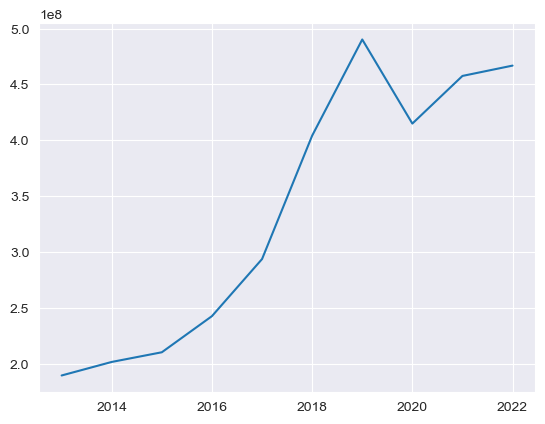

In [12]:
# Plot the team values across seasons
clubs_val = []
for year in range(2013, 2023, 1):
    dframe = locals()[f'dfvalue_{year}']
    clubs_val.append(dframe['TotValue'].mean())
sns.lineplot(x=range(2013, 2023, 1), y=clubs_val)

In [ ]:
clubs = []
palette = sns.color_palette("bright")
sns.set(font_scale=1.1)
team_list = ['Manchester City', 'Liverpool', 'Arsenal', 'Manchester United', 'Chelsea', 'Tottenham Hotspur']
for teams in team_list:
    clubs_pts = []
    for year in range(2014, 2023, 1):
        dframe = locals()[f'df_{year}']
        clubs_pts.append(dframe[dframe.Team==teams].index[0]+1)
    clubs.append(clubs_pts)
    sns.set_palette("bright")
    ax = sns.lineplot(x=range(2014, 2023, 1), y=clubs_pts, palette='bright')

plt.xlabel(xlabel='Season')
plt.ylabel(ylabel='League Position')
plt.legend(team_list, title='Team')
plt.yticks(range(19,-1,-2))
ax.invert_yaxis()
plt.grid(False)
plt.show()

In [ ]:
# Look at 2 features over the seasons

rows = 3
cols = 3
year_start = 2023-rows*cols

counter=0
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=False)
fig.tight_layout(pad=3.0)

for row in range(3):
    for col in range(3):
        df_plot = locals()['df_{}'.format(year_start+counter)]
        sns.scatterplot(ax=axes[row,col],
                        x=df_plot['Pts'], y=df_plot['annual_wage']/1000000,
                        c=df_plot['target'], cmap='viridis')
        axes[row,col].set_title(f'{year_start+counter}')
        axes[row,col].set_xlabel(xlabel='')
        axes[row,col].set_ylabel(ylabel='')
        counter += 1

axes[2,1].set_xlabel(xlabel='League points')
axes[1,0].set_ylabel(ylabel='Annual total payroll (£million)')

In [ ]:
# Do the same for 2 different features

counter=0
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=False)
fig.tight_layout(pad=3.0)

for row in range(3):
    for col in range(3):
        df_plot = locals()['df_{}'.format(year_start+counter)]
        sns.scatterplot(ax=axes[row,col],
                        x=df_plot['Pts'], y=locals()['dftransfer_{}'.format(year_start+counter)]['net_spend'],
                        c=df_plot['target'], cmap='viridis')
        axes[row,col].set_title(f'{year_start+counter}')
        axes[row,col].set_xlabel(xlabel='')
        axes[row,col].set_ylabel(ylabel='')
        counter += 1

axes[2,1].set_xlabel(xlabel='League points')
axes[1,0].set_ylabel(ylabel='Net Spend (£million)')

# Clustering using KMeans
###### Take one season, 2022, and investigate the model a bit

In [ ]:
# Check the scaling works
scaler = MinMaxScaler()
num_cols = df_2022.drop(columns='target').select_dtypes(include=np.number).columns
df_scaled = scaler.fit_transform(df_2022[num_cols])
df_scaled

In [ ]:
# Implement scaling on the numerical columns
scaler = MinMaxScaler()
num_cols = df_2022.drop(columns='target').select_dtypes(include=np.number).columns
df_scaled = scaler.fit_transform(df_2022[num_cols])

# Plot sillouette sores and WCSS (inertia) for a range of cluster numbers
k_range = range(2, 6)
scores = []
inertia = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=124)
    km.fit(df_scaled)
    scores.append(metrics.silhouette_score(df_scaled, km.labels_))
    inertia.append(km.inertia_)
# Plot scores
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.grid(True)
plt.show()

In [ ]:
# Take a visual look at the clustering
km = KMeans(n_clusters=2, random_state=124)
km.fit(df_scaled)

# Measure against correct result
df_measure = df_2022.copy()
df_measure['cluster'] = km.labels_

# Plot the labelled clusters for 3 different pairs of features
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=3.0)
feats = ['annual_wage','TotValue','net_spend']
for col in range(3):
    sns.scatterplot(ax=axes[col],
                    x=df_measure['Pts'], y=df_measure[feats[col]],
                    c=df_measure['target'], cmap='viridis',style=df_measure['cluster'], legend=False)
    axes[col].set_xlabel(xlabel='League points')
    axes[col].set_ylabel(ylabel=feats[col])
    # Annotate label points
    for i, team_abb in enumerate(df_2022.abb):
        axes[col].annotate(team_abb, (df_measure.loc[i,'Pts']+1, df_measure.loc[i,feats[col]]+3))

In [ ]:
# Repeat for the other 2 numerical features
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=3.0)
feats = ['att_percent','total_spend']
for col in range(2):
    sns.scatterplot(ax=axes[col],
                    x=df_measure['Pts'], y=df_measure[feats[col]],
                    c=df_measure['target'], cmap='viridis',style=df_measure['cluster'], legend=False)
    axes[col].set_xlabel(xlabel='League points')
    axes[col].set_ylabel(ylabel=feats[col])
    # Annotate label points
    for i, team_abb in enumerate(df_2022.abb):
        axes[col].annotate(team_abb, (df_measure.loc[i,'Pts']+1, df_measure.loc[i,feats[col]]+3))

##### Judge it visually from another angle. Try implementing PCA

In [ ]:
pca = PCA(n_components=df_scaled.shape[1], svd_solver = 'auto')
pca.fit_transform(df_scaled)
#
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
# Apply optimal PCA to the 2022 season df
X_pca = PCA(n_components=4, svd_solver = 'auto', random_state=10).fit_transform(df_scaled)
globals()['X_pca{}'.format(2022)] = X_pca
# Kmeans with n=2
kmeans = KMeans(n_clusters= 2, random_state=124)
label = kmeans.fit_predict(X_pca)

# Plot the PCA values
# Add target and predicted labels to the PCA array (for annotation/labelling)
X_pca = np.c_[X_pca, df_2022['target']]
X_pca = np.c_[X_pca, label]

centroids = kmeans.cluster_centers_
sns.scatterplot(x=X_pca[:,0] , y=X_pca[:,1] , c=X_pca[:,4], cmap='viridis', style=X_pca[:,5], s=100, legend=False)
sns.scatterplot(x=centroids[:,0] , y=centroids[:,1] , s = 80, color = 'k', legend=False)
# Annotate label points
for i, language in enumerate (df_2022.abb):
    plt.annotate(language, (X_pca[i,0]+0.02, X_pca[i,1]+0.02))
plt.show()